In [ ]:
%%bash
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d761a28cd31105b37042bce49d8ade7b711e4e90f92c025b7f90206e6f188c34
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

# for data
from google.colab import drive

# Data & Preprocessing

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
credits = pd.read_csv('./drive/MyDrive/data/tmdb_5000_credits.csv')
movies = pd.read_csv('./drive/MyDrive/data/tmdb_5000_movies.csv')

In [ ]:
credits.columns = ['id','tittle','cast','crew']
movies = movies.merge(credits, on='id')

In [ ]:
movies['overview'] = movies['overview'].fillna('')

In [ ]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'tittle', 'cast', 'crew'],
      dtype='object')

In [ ]:
movies[(movies['vote_average'] < 4) & (movies['vote_average'] > 0)]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
272,90000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,24113,"[{""id"": 2301, ""name"": ""architect""}, {""id"": 345...",en,Town & Country,Porter Stoddard is a well-known New York archi...,1.004579,"[{""name"": ""New Line Cinema"", ""id"": 12}]",...,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,There's no such thing as a small affair.,Town & Country,3.7,16,Town & Country,"[{""cast_id"": 3, ""character"": ""Porter Stoddard""...","[{""credit_id"": ""52fe4483c3a368484e02742d"", ""de..."
309,84000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 35, ""na...",NaN,10214,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 2546, ""n...",en,Son of the Mask,"Tim Avery, an aspiring cartoonist, finds himse...",17.815595,"[{""name"": ""New Line Cinema"", ""id"": 12}, {""name...",...,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Who's next?,Son of the Mask,3.6,338,Son of the Mask,"[{""cast_id"": 1, ""character"": ""Tim Avery"", ""cre...","[{""credit_id"": ""52fe43439251416c75009b91"", ""de..."
480,44000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",NaN,5491,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,Battlefield Earth,"In the year 3000, man is no match for the Psyc...",7.891470,"[{""name"": ""Franchise Pictures"", ""id"": 1403}, {...",...,118.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Take Back The Planet,Battlefield Earth,3.0,255,Battlefield Earth,"[{""cast_id"": 11, ""character"": ""Terl"", ""credit_...","[{""credit_id"": ""52fe4409c3a36847f807e759"", ""de..."
503,76000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,17711,"[{""id"": 4414, ""name"": ""adventure""}, {""id"": 651...",en,The Adventures of Rocky & Bullwinkle,Rocky and Bullwinkle have been living off the ...,8.981427,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...",...,88.0,"[{""iso_639_1"": ""ru"", ""name"": ""P\u0443\u0441\u0...",Released,This summer it's not the same old bull.,The Adventures of Rocky & Bullwinkle,3.9,87,The Adventures of Rocky & Bullwinkle,"[{""cast_id"": 1, ""character"": ""Natasha"", ""credi...","[{""credit_id"": ""593c9f81c3a3680f4201597d"", ""de..."
601,0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",NaN,11535,"[{""id"": 554, ""name"": ""manager""}, {""id"": 1395, ...",en,Rollerball,From the director of Die Hard comes this high-...,9.306253,"[{""name"": ""Atlas Entertainment"", ""id"": 507}, {...",...,98.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...",Released,Go Ballistic,Rollerball,3.4,106,Rollerball,"[{""cast_id"": 1, ""character"": ""Jonathan Cross"",...","[{""credit_id"": ""54b88dfc92514148b00007aa"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,75000,"[{""id"": 878, ""name"": ""Science Fiction""}]",NaN,360188,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 9970,...",en,Queen Crab,A meteor crashes into a quiet lake in the remo...,0.140989,"[{""name"": ""Polonia Brothers Entertainment"", ""i...",...,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Queen Crab,3.3,3,Queen Crab,"[{""cast_id"": 2, ""character"": ""Melissa Webber"",...","[{""credit_id"": ""562f43829251410a22008ae9"", ""de..."
4764,0,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 18, ""n...",NaN,326576,[],en,Dawn of the Crescent Moon,A group of college students travel to a small ...,0.049469,[],...,95.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The past is present.,Dawn of the Crescent Moon,2.0,1,Dawn of the Crescent Moon,"[{""cast_id"": 8, ""character"": ""Cyrus"", ""credit_...","[{""credit_id"": ""54e889e7925141117c0014b7"", ""de..."
4765,0,"[{""id"": 27, ""name"": ""Horror""}]",https://www.facebook.com/pages/R

In [ ]:
for item in temp:
    print(item)

Dex, a superdog sleuth, is the law of the land when the world's most recognized brands take on the forces of evil and the devilish Brand X.
In this action thriller set in post-Katrina New Orleans, business owner Jack Vermillion (Laurence Fishburne) is struggling to run a legitimate shipping company while bad guy Ernest Pike (Karl Urban) is struggling to get his family's illegal gun collection out of the country. When their paths collide, Jack realizes that exposing Pike might get him just the sway he needs to persuade law enforcement officials to treat his imprisoned son kindly.
The young warrior Son Goku sets out on a quest, racing against time and the vengeful King Piccolo, to collect a set of seven magical orbs that will grant their wielder unlimited power.
Following on from the plot of the last movie, babies can communicate with each other using 'baby talk', and have an innate knowledge of the secrets of the universe. The baby geniuses become involved in a scheme by media mogul Bil

# Movie overview --> Vector

In [ ]:
def get_X(data=movies['overview'], vectorizer='bert'):
    X = None
    
    if vectorizer == 'tfidf':
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        X = tfidf_vectorizer.fit_transform(data).toarray()
    elif vectorizer == 'bert':
        bert = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = []
        for sentence in tqdm(data):
            embedding = bert.encode(sentence)
            embeddings.append(embedding)
        X = embeddings
    else:
        raise NotImplementedError

    return np.array(X)

In [ ]:
X = get_X(data=movies['overview'], vectorizer='tfidf')

In [ ]:
y = np.array(movies['vote_average'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3842, 20978) (961, 20978) (3842,) (961,)


In [ ]:
X_train = torch.from_numpy(X_train.astype(np.float64))
y_train = torch.from_numpy(y_train.astype(np.float64))
y_train = y_train.view(y_train.shape[0], 1)

X_test = torch.from_numpy(X_test.astype(np.float64))
y_test = torch.from_numpy(y_test.astype(np.float64))
y_test = y_test.view(y_test.shape[0], 1)

# Model

In [ ]:
EPOCHS = 10
INPUT_SIZE = 20978
HIDDEN_SIZE = 256
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-3
EPS = 1e-4

In [ ]:
X = X_train
y = y_train

model = torch.nn.Sequential(
    torch.nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    torch.nn.ReLU(torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)),
    torch.nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
).double()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
losses = []

for epoch in tqdm(range(EPOCHS)):
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.item())

    if len(losses) >= 2 and losses[-1] - losses[-2] >= EPS:
        break

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


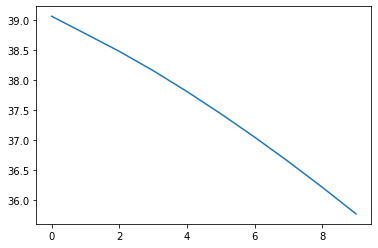

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
predicted = model(X_test).detach().numpy()
r2_score(y_test, predicted)

-22.687438386635307